In [13]:
#Module Imports
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc
from tqdm.notebook import trange, tqdm
import glob
from scipy import ndimage
import cv2

from itertools import chain
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from keras import backend as K

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


In [14]:
#Image size definition and check
w, h = 256,256
border = 5 
ids = next(os.walk("D:\\Mestrado\\DRMicro\\ProjetoFinal\\ClipsTreino\\"))[2]
print("No. of images = ", len(ids))

No. of images =  2398


In [15]:
#Imaage vs Mask vector size check
train = sorted(glob.glob("D:\\Mestrado\\DRMicro\\ProjetoFinal\\ClipsTreino\\*"))
train_mask = sorted(glob.glob("D:\\Mestrado\\DRMicro\\ProjetoFinal\\Mascaras\\*"))
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 2398
Total Mask Image : 2398


In [16]:
#Create empty arrays
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [17]:
#Image load
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = cv2.imread("D:\\Mestrado\\DRMicro\\ProjetoFinal\\ClipsTreino\\"+id_, cv2.IMREAD_ANYDEPTH)
    x_img = np.array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    msk = cv2.imread("D:\\Mestrado\\DRMicro\\ProjetoFinal\\Mascaras\\"+id_, cv2.IMREAD_ANYDEPTH)
    mask = np.array(msk)
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    mask
    # Save images
    y[n] = mask/255
    X[n] = ndimage.filters.median_filter(x_img, 9)
    X[n] = X[n] /255

  0%|          | 0/2398 [00:00<?, ?it/s]

In [18]:
print(X.shape, y.shape)

(2398, 256, 256, 3) (2398, 256, 256, 1)


In [19]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(1918, 256, 256, 3) (1918, 256, 256, 1) (480, 256, 256, 3) (480, 256, 256, 1)


68

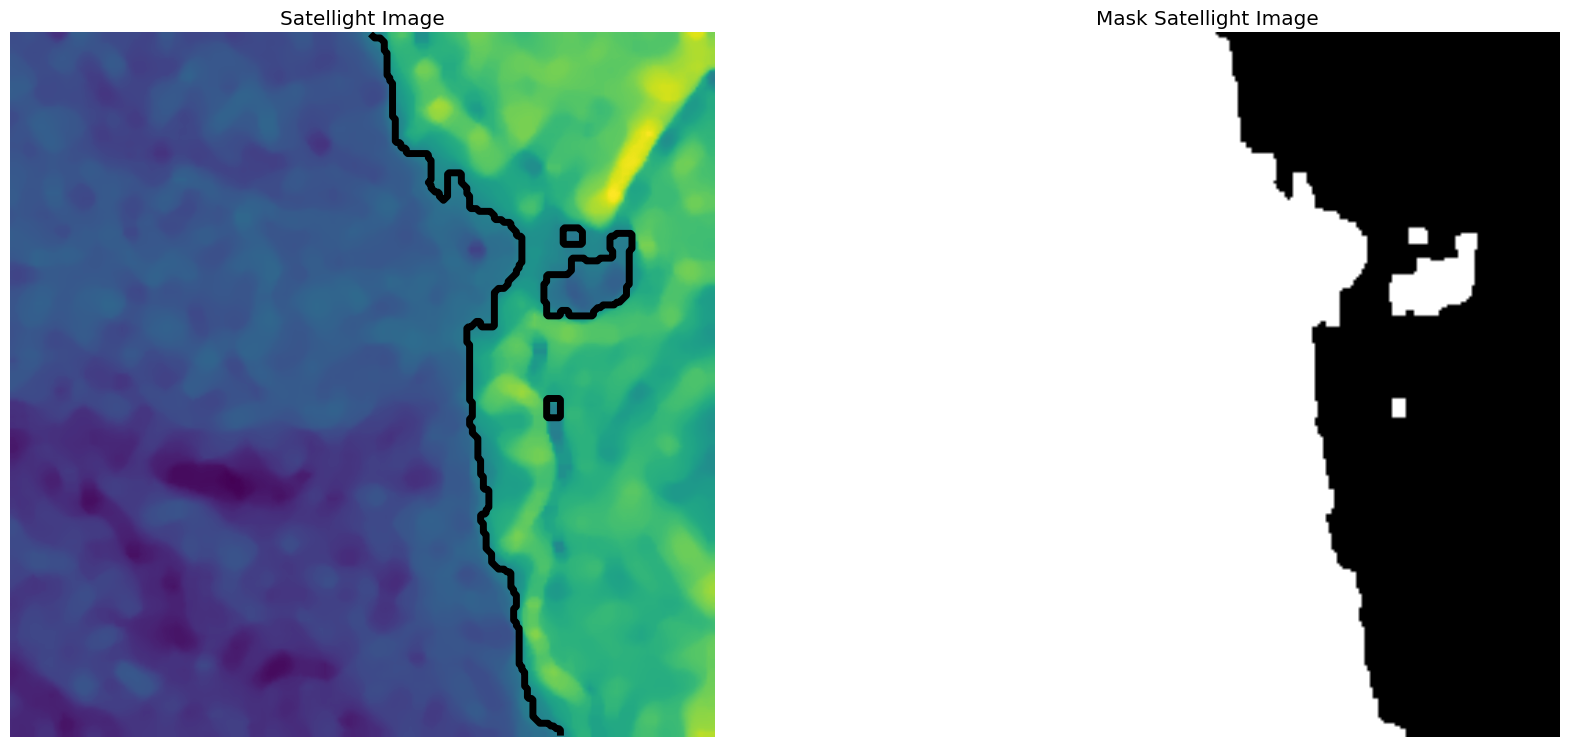

In [20]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Imagem Satelite')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mascara')
ax2.set_axis_off()

In [21]:
#Definition of the U-Net Model
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    else:
        x= Activation("relu")(x)
    return x


def VGGUnet(image_size, vgg_weight_path=None):
    inputs = Input((image_size, image_size, 3))
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(inputs, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
K.clear_session()

# input_img = Input((h, w, 3), name='img')
model = VGGUnet(image_size = 256)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [24]:
#Definition of model saving and stopping conditions, learn rates
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ResUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [25]:
#Fitting the model
results = model.fit(X_train, y_train, batch_size=6, epochs=100, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)


Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.9122 - auc: 0.9551 - sensitivity_at_specificity: 0.9933 - specificity_at_sensitivity: 0.9738
Epoch 1: val_loss improved from inf to 0.63341, saving model to model-ResUnet.h5
320/320 [==============================] - 3246s 10s/step - loss: 0.3711 - accuracy: 0.9122 - auc: 0.9551 - sensitivity_at_specificity: 0.9933 - specificity_at_sensitivity: 0.9738 - val_loss: 0.6334 - val_accuracy: 0.6145 - val_auc: 0.9539 - val_sensitivity_at_specificity: 0.9825 - val_specificity_at_sensitivity: 0.9699 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.9103 - auc: 0.9539 - sensitivity_at_specificity: 0.9913 - specificity_at_sensitivity: 0.9705 
Epoch 2: val_loss improved from 0.63341 to 0.29873, saving model to model-ResUnet.h5
320/320 [==============================] - 3423s 11s/step - loss: 0.3249 - accuracy: 0.9103 - auc: 0.9539 - sensitivity_at_speci

In [57]:
#Table output of model training
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result.to_excel('results.xlsx')

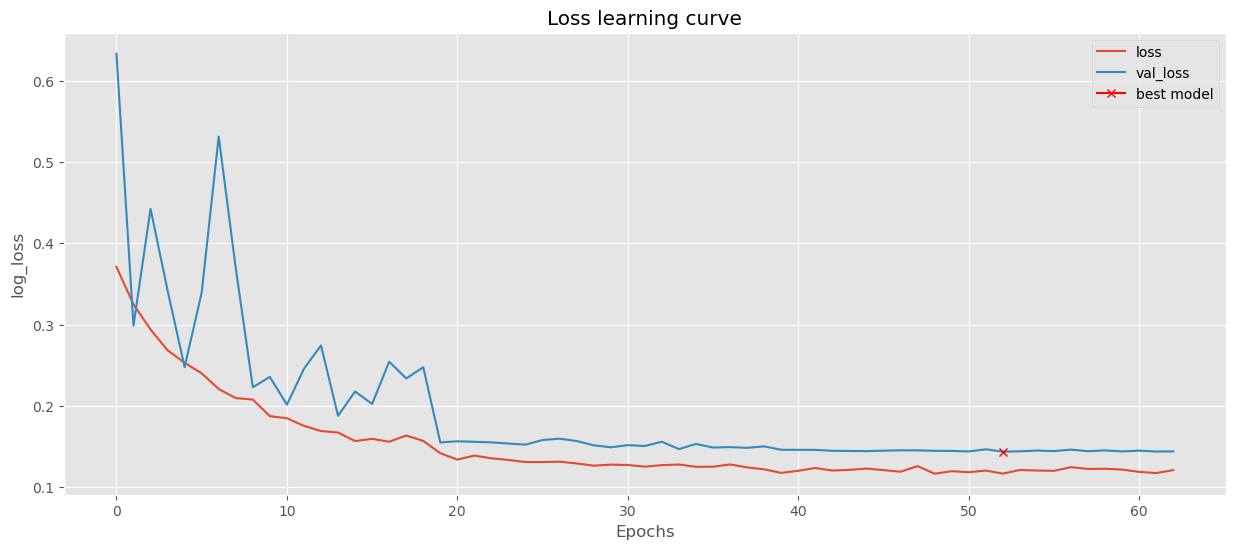

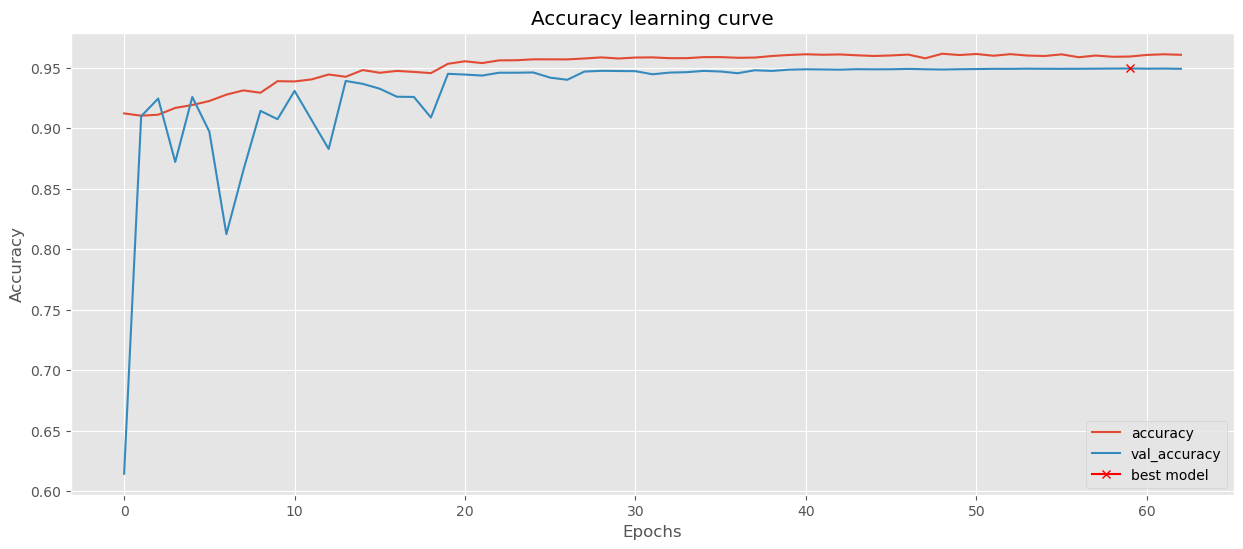

In [27]:
#Graph output of model training
plt.figure(figsize = (15,6))
plt.title("Loss learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Accuracy learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [28]:
#load the best model
model.load_weights('model-ResUnet.h5')

In [29]:
#Evaluation of the model on the validation dataset, should match the best model above
model.evaluate(X_test, y_test, verbose=1)

15/15 [==============================] - 200s 13s/step - loss: 0.1437 - accuracy: 0.9490 - auc: 0.9858 - sensitivity_at_specificity: 0.9984 - specificity_at_sensitivity: 0.9961


[0.14366936683654785,
 0.949015200138092,
 0.9858075976371765,
 0.9984266757965088,
 0.9960795640945435]

In [30]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

15/15 [==============================] - 195s 13s/step


In [104]:
# Threshold predictions
preds_train_t = (preds_train> 0.70)
preds_val_t = (preds_val > 0.5)

In [105]:
#Visualise training outputs
def plot_sample(X, y, preds, ix=None):

    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellite Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Training Labels')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), cmap='seismic')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Training Prediction')
    ax[2].set_axis_off()
    

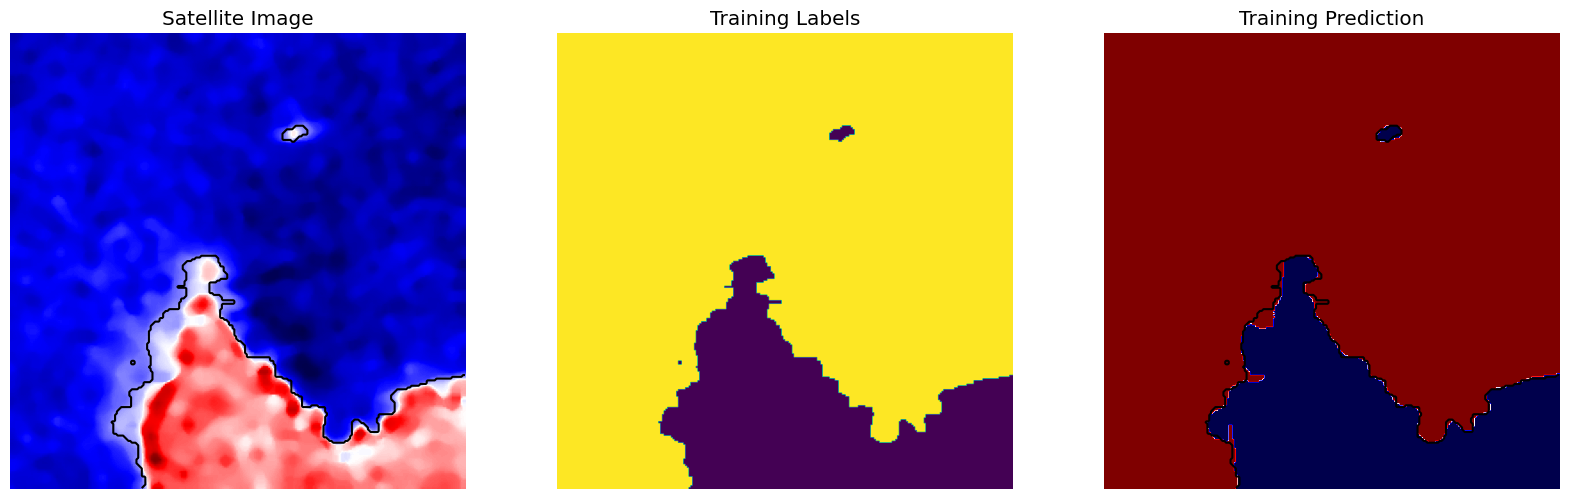

In [108]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_t, ix=1005)

In [283]:
#Use the model to segment any image set

input_dir_test="D:\\Mestrado\\DRMicro\\ProjetoFinal\\ClipsFinal\\20221126\\"
result_dir_test="D:\\Mestrado\\DRMicro\\ProjetoFinal\\ClipsFinal\\2022Results\\"
input_channel_count=1

ids_teste = next(os.walk(input_dir_test))[2]
X_t = np.zeros((len(ids_teste), h, w, 3), dtype=np.float32)

# tqdm is used to display the progress bar
for n, filename in tqdm(enumerate(ids_teste), total=len(ids_teste)):
    # Load images
    img_t = cv2.imread(input_dir_test+filename, cv2.IMREAD_ANYDEPTH)
    x_img_t = np.array(img_t)
    x_img_t = resize(x_img_t, (256, 256, 1), mode = 'constant', preserve_range = True)
    X_t[n] = ndimage.filters.median_filter(x_img_t, 9)
    X_t[n] = X_t[n] /255


model.load_weights('model-ResUnet.h5')
batch_size=6

Y_pred = model.predict(X_t,batch_size)
for i, y in enumerate(Y_pred>0.95):
   
   cv2.imwrite (result_dir_test+os.sep+ids_teste[i],y*255)

  0%|          | 0/32 [00:00<?, ?it/s]

6/6 [==============================] - 12s 2s/step


In [263]:

# This code validates the test dataset classification vs test training labels
flat_lista = []
flat_listb = []

dira='D:\\Mestrado\\DRMicro\\ProjetoFinal\\TestSetMasks\\'
dirb='D:\\Mestrado\\DRMicro\\ProjetoFinal\\TestSetResults\\'

for filename in os.listdir(dira):
    a=cv2.imread(dira+filename, cv2.IMREAD_ANYDEPTH)
    a=(a/255).astype(int)
    for sublist in a:
         for item in sublist:
             flat_lista.append(item)

for filename in os.listdir(dirb):
    b=cv2.imread(dirb+filename, cv2.IMREAD_ANYDEPTH)
    b=(b/255).astype(int)
    for sublist in b:
        for item in sublist:
            flat_listb.append(item)

#confusion_matrix(a,b)
cm=confusion_matrix(flat_lista,flat_listb)
tn, fp, fn, tp = confusion_matrix(flat_lista,flat_listb).ravel()
print(classification_report(flat_lista,flat_listb))
print(cm)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Mestrado\\DRMicro\\ProjetoFinal\\TestSetResultsb\\'